**What is the differences between RNN & LSTM?**

Before I tell you what is LSTM let me tell you about the biggest problem with RNNs. So far everything looks good about RNNs until we train it via back-propagation. As the gradient of our training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.

<a href="https://ibb.co/"><img src="https://i.ibb.co/3yN3G91/rnn-vs-lstm.jpg" alt="resim_a" border="2"></a>

*We will use our 50 datas to predict 51th data. Also I will take first 200000 datas*

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


import os
#print(os.listdir("../input"))


In [3]:
bit_data=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

What I did here? I added a colum which is "date" and I converted "Timestamp" columns to date form.

In [5]:
data.shape

(2627,)

In [160]:
bit_data.shape
#bit_data.head(24*60)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


In [6]:
data.isnull().sum()

0

In [10]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

The goal is making a prediction of daily close datas. So we will predict "close" values of bitcoin datas

**First I will use RNN to predict our datas**

I am separating last 50 rows for test data.

In [11]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

Here I will set our values between 0-1 in order to avoid domination of bigger values.

In [12]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

Let's choose every 50 datas as x-train and 51th as y-train

In [92]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


Time to prepare and run our RNN method

In [15]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [28]:
es = EarlyStopping(monitor='val_loss',min_delta = 0.0005,patience =5,restore_best_weights=False)
#cp = ModelCheckpoint(filepath ='best_model.h5', monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')
#rLRoP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callback = [es]#,cp,rLRoP];

In [40]:
regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))


In [43]:
regressor.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])
regressor.fit(x_train,y_train,epochs=20,batch_size=64, callbacks = callback)

Epoch 1/20
2527/2527 [==============================] - 51s 20ms/step - loss: 0.0072 - acc: 7.9145e-04
Epoch 2/20
2527/2527 [==============================] - 46s 18ms/step - loss: 0.0018 - acc: 7.9145e-04
Epoch 3/20
2527/2527 [==============================] - 45s 18ms/step - loss: 0.0016 - acc: 7.9145e-04
Epoch 4/20
2527/2527 [==============================] - 53s 21ms/step - loss: 0.0014 - acc: 7.9145e-04
Epoch 5/20
2527/2527 [==============================] - 50s 20ms/step - loss: 0.0011 - acc: 7.9145e-04
Epoch 6/20
2527/2527 [==============================] - 47s 19ms/step - loss: 0.0015 - acc: 7.9145e-04
Epoch 7/20
2527/2527 [==============================] - 43s 17ms/step - loss: 8.2857e-04 - acc: 7.9145e-04
Epoch 8/20
2527/2527 [==============================] - 45s 18ms/step - loss: 9.0987e-04 - acc: 7.9145e-04
Epoch 9/20
2527/2527 [==============================] - 52s 21ms/step - loss: 6.7189e-04 - acc: 7.9145e-04
Epoch 10/20
2527/2527 [==============================] - 41s 

Now we are preparing our test data for prediction

In [44]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [71]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test.shape

(50, 50, 1)

In [46]:
predicted_data_RNN=regressor.predict(x_test)
predicted_data_RNN=scaler.inverse_transform(predicted_data_RNN)

**What did we do???? We learnt our model with train datas and then we tried to predict next 50 datas (train data=50). Then we compared predictions with our test (real) datas.**

In [47]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

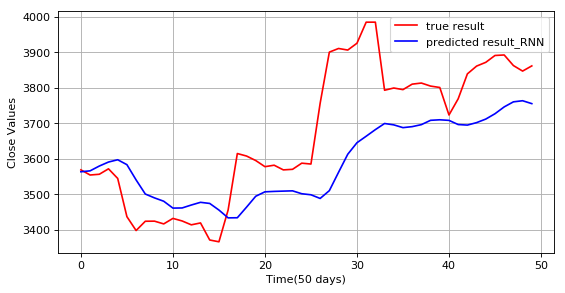

In [48]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_RNN,color="b",label="predicted result_RNN")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Here we have the results of our prediction. As we can see on the chart that with RNN method we don't have a good result. So let's check LSTM method, then we can compare both results.

**Keep going with LSTM method**

I will use the same train and test datas

In [135]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten


In [136]:
x_train.shape

(2527, 50, 1)

In [168]:
model=Sequential()

model.add(LSTM(10,activation="relu",input_shape=(None,1)))

model.add(Dense(1))

In [169]:
model.compile(loss="mean_squared_error",optimizer="adam")#,callbacks = callback)
#activation='tanh', recurrent_activation='hard_sigmoid'
model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2527/2527 [==============================] - 16s 6ms/step - loss: 0.0102
Epoch 2/100
2527/2527 [==============================] - 4s 2ms/step - loss: 6.1788e-04
Epoch 3/100
2527/2527 [==============================] - 4s 2ms/step - loss: 4.8319e-04
Epoch 4/100
2527/2527 [==============================] - 4s 2ms/step - loss: 4.3202e-04A: 0s - loss: 4.3231e-0
Epoch 5/100
2527/2527 [==============================] - 4s 2ms/step - loss: 3.8114e-04
Epoch 6/100
2527/2527 [==============================] - 4s 2ms/step - loss: 3.4242e-04
Epoch 7/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.9230e-04
Epoch 8/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.7210e-04
Epoch 9/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.3838e-04
Epoch 10/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.4667e-04
Epoch 11/100
2527/2527 [==============================] - 4s 2ms/step - loss: 2.3225e-04
Epoch 12/1

In [164]:
model2=Sequential()

model2.add(LSTM(20,activation="relu",return_sequences=True,input_shape=(None,1)))

#model2.add(Dropout(0.9))

model2.add(LSTM(20,return_sequences=True,activation="relu"))

model2.add(LSTM(20,activation="relu"))

#model2.add(Dropout(0.9))

model2.add(Dense(1))

In [165]:
model2.compile(loss="mean_squared_error",optimizer="adam")#,callbacks = callback)
#activation='tanh', recurrent_activation='hard_sigmoid'
model2.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2527/2527 [==============================] - 25s 10ms/step - loss: 0.0248
Epoch 2/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0084
Epoch 3/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0018
Epoch 4/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0016
Epoch 5/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0015
Epoch 6/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0013
Epoch 7/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0012
Epoch 8/100
2527/2527 [==============================] - 10s 4ms/step - loss: 0.0010
Epoch 9/100
2527/2527 [==============================] - 10s 4ms/step - loss: 8.4531e-04
Epoch 10/100
2527/2527 [==============================] - 10s 4ms/step - loss: 8.4101e-04
Epoch 11/100
2527/2527 [==============================] - 10s 4ms/step - loss: 8.3266e-04
Epoch 12/100
2527/2527 [==========================

Keep going with test data

In [170]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [171]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

it's time to predict

In [172]:
predicted_data_LSTM1=model.predict(x_test)
predicted_data_LSTM1=scaler.inverse_transform(predicted_data_LSTM1)

In [173]:
predicted_data_LSTM2=model2.predict(x_test)
predicted_data_LSTM2=scaler.inverse_transform(predicted_data_LSTM2)

In [174]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

In [1]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
#plt.plot(predicted_data_RNN,color="g",label="predicted result_RNN")
plt.plot(predicted_data_LSTM1,color="b",label="predicted result_LSTM1")
plt.plot(predicted_data_LSTM2,color="y",label="predicted result_LSTM2")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

* ** Conclusion**

When we compare the both results (RNN and LSTM) we can see that we have better prediction with LSTM. 

Up to here I was trying to show the differences between RNN and LSTM. If you have any question or I have any error please write me dirctly.
